In [13]:
import pandas as pd
import numpy as np

# 1. Load the Data
print("Loading data...")
app_train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')

print(f"Application Data Shape: {app_train.shape}")
print(f"Bureau Data Shape: {bureau.shape}")

# 2. Feature Engineering on Bureau Data (The "Satellite")
# We need to collapse multiple bureau records into one profile per customer.
# Logic: "How much debt does this person already have elsewhere?"

bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',           # Count total past loans
    'AMT_CREDIT_SUM': 'sum',           # Total external debt
    'AMT_CREDIT_SUM_OVERDUE': 'sum',   # Total overdue debt
    'DAYS_CREDIT': 'max'               # How recent was their last loan?
}).reset_index()

# Rename columns to make them clear in the final table
bureau_agg.columns = ['SK_ID_CURR', 'TOTAL_PAST_LOANS', 'TOTAL_PAST_DEBT', 'TOTAL_OVERDUE_DEBT', 'LAST_LOAN_DAYS']

# 3. Merge with Main Application (The "Hub")
# Left Join: Keep all current applicants, even if they have no bureau history.
df_master = app_train.merge(bureau_agg, on='SK_ID_CURR', how='left')

# 4. Fill NULLs (Crucial for Risk Models)
# If no bureau match, it means they have 0 past loans, not "NaN".
cols_to_fix = ['TOTAL_PAST_LOANS', 'TOTAL_PAST_DEBT', 'TOTAL_OVERDUE_DEBT']
df_master[cols_to_fix] = df_master[cols_to_fix].fillna(0)

# 5. Create New Financial Ratios
df_master['DEBT_TO_INCOME_RATIO'] = df_master['AMT_CREDIT'] / df_master['AMT_INCOME_TOTAL']
df_master['CREDIT_UTILIZATION_RATIO'] = df_master['TOTAL_PAST_DEBT'] / (df_master['AMT_INCOME_TOTAL'] + 1) # +1 avoids div by zero

print("Master Table Created.")
print(df_master[['SK_ID_CURR', 'TARGET', 'TOTAL_PAST_LOANS', 'DEBT_TO_INCOME_RATIO']].head())

Loading data...
Application Data Shape: (307511, 122)
Bureau Data Shape: (1716428, 17)
Master Table Created.
   SK_ID_CURR  TARGET  TOTAL_PAST_LOANS  DEBT_TO_INCOME_RATIO
0      100002       1               8.0              2.007889
1      100003       0               4.0              4.790750
2      100004       0               2.0              2.000000
3      100006       0               0.0              2.316167
4      100007       0               1.0              4.222222


In [14]:
# ... (Previous code for app_train and bureau goes here) ...

# 1. Load the Previous Application Data
print("Loading Previous Applications...")
prev_app = pd.read_csv('previous_application.csv')

# 2. Advanced Feature Engineering: Contract Status
# Instead of just counting rows, we want to know specifics: "Refused" vs "Approved"
# We use get_dummies to turn categorical text into binary columns (0 or 1)
prev_status_dummies = pd.get_dummies(prev_app['NAME_CONTRACT_STATUS'], prefix='PREV_STATUS')
prev_app = pd.concat([prev_app, prev_status_dummies], axis=1)

# 3. Aggregate by Customer ID (SK_ID_CURR)
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',                   # Total number of previous apps
    'AMT_CREDIT': 'mean',                    # Average credit amount requested
    'PREV_STATUS_Approved': 'sum',           # Count of approvals
    'PREV_STATUS_Refused': 'sum',            # Count of rejections (CRITICAL SIGNAL)
    'PREV_STATUS_Canceled': 'sum'            # Count of cancellations
}).reset_index()

# Rename columns for clarity
prev_agg.rename(columns={
    'SK_ID_PREV': 'PREV_APP_COUNT',
    'AMT_CREDIT': 'PREV_AVG_CREDIT_REQUEST'
}, inplace=True)

# 4. Calculate "Rejection Ratio" (High Value Feature)
# If a user has 5 applications and 4 were refused, they are high risk.
prev_agg['PREV_REJECTION_RATIO'] = prev_agg['PREV_STATUS_Refused'] / prev_agg['PREV_APP_COUNT']

# 5. Merge into Master Table
# Left Join again: We want to keep all current applicants
df_master = df_master.merge(prev_agg, on='SK_ID_CURR', how='left')

# 6. Fill NULLs
# If no match, it means 0 previous applications
new_cols = ['PREV_APP_COUNT', 'PREV_AVG_CREDIT_REQUEST', 'PREV_STATUS_Approved',
            'PREV_STATUS_Refused', 'PREV_STATUS_Canceled', 'PREV_REJECTION_RATIO']
df_master[new_cols] = df_master[new_cols].fillna(0)

print("Previous Applications Integrated.")
print(df_master[['SK_ID_CURR', 'PREV_APP_COUNT', 'PREV_STATUS_Refused', 'PREV_REJECTION_RATIO']].head())

Loading Previous Applications...
Previous Applications Integrated.
   SK_ID_CURR  PREV_APP_COUNT  PREV_STATUS_Refused  PREV_REJECTION_RATIO
0      100002             1.0                  0.0              0.000000
1      100003             3.0                  0.0              0.000000
2      100004             1.0                  0.0              0.000000
3      100006             9.0                  1.0              0.111111
4      100007             6.0                  0.0              0.000000


     REJECTION_BIN     TARGET
0     0 Rejections   6.984466
1      Low (0-20%)   7.688620
2  Medium (20-50%)  10.776156
3      High (>50%)  15.925793


/var/folders/51/p3lrk4bn4xs2r103jpgsf7gh0000gn/T/ipykernel_35797/2319104761.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_analysis = df_master.groupby('REJECTION_BIN')['TARGET'].mean().reset_index()
/var/folders/51/p3lrk4bn4xs2r103jpgsf7gh0000gn/T/ipykernel_35797/2319104761.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='REJECTION_BIN', y='TARGET', data=risk_analysis, palette='Reds')


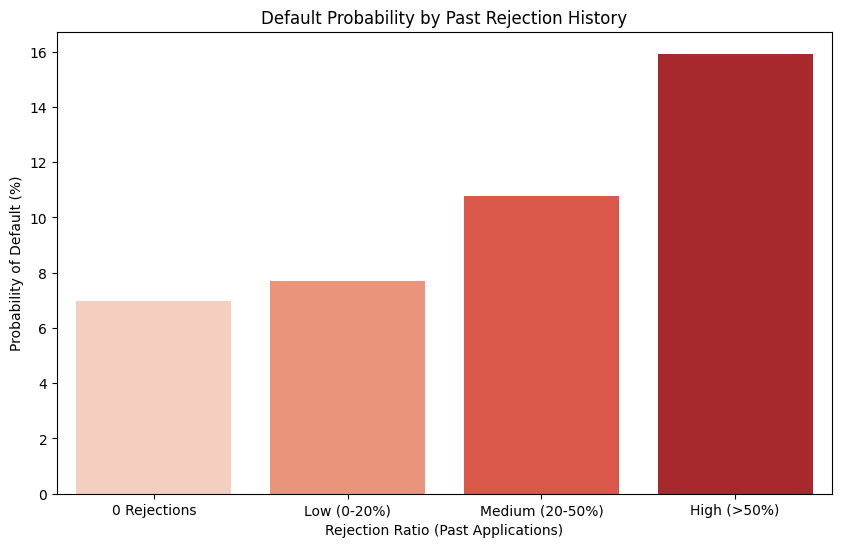

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create Bins for Rejection Ratio
# We group people into categories: "Never Rejected", "Low Rejection", "High Rejection"
bins = [-1, 0, 0.2, 0.5, 1.0]
labels = ['0 Rejections', 'Low (0-20%)', 'Medium (20-50%)', 'High (>50%)']
df_master['REJECTION_BIN'] = pd.cut(df_master['PREV_REJECTION_RATIO'], bins=bins, labels=labels)

# 2. Calculate Default Rate per Bin
# We average the 'TARGET' column (since 1=Default, the mean is the % rate)
risk_analysis = df_master.groupby('REJECTION_BIN')['TARGET'].mean().reset_index()

# Convert to percentage for easier reading
risk_analysis['TARGET'] = risk_analysis['TARGET'] * 100

print(risk_analysis)

# 3. Visualize It
plt.figure(figsize=(10, 6))
sns.barplot(x='REJECTION_BIN', y='TARGET', data=risk_analysis, palette='Reds')
plt.title('Default Probability by Past Rejection History')
plt.ylabel('Probability of Default (%)')
plt.xlabel('Rejection Ratio (Past Applications)')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve


obj_cols = df_master.select_dtypes(include=['object']).columns

print(f"Converting {len(obj_cols)} text columns to categories: {list(obj_cols)}")

# 2. Loop through and convert them to 'category' type
for col in obj_cols:
    df_master[col] = df_master[col].astype('category')

# 3. Now verify they are no longer "object"
print("Data types fixed. Ready for training.")

# 1. Prepare the Data
# Drop the ID (not a predictor) and the Target
X = df_master.drop(columns=['SK_ID_CURR', 'TARGET', 'REJECTION_BIN']) # Drop the bin helper column too
y = df_master['TARGET']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train the Model
print("Training LightGBM Model...")
model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

model.fit(X_train, y_train)

# 3. Evaluate Performance
# In Credit Risk, we use "AUC" (Area Under Curve), not just "Accuracy".
# AUC = 0.5 is random guessing. AUC > 0.7 is good.
y_pred_prob = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Model trained. ROC-AUC Score: {auc_score:.4f}")

# 4. Feature Importance (The "Why")
# This tells you which columns drove the decision.
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Risk Drivers:")
print(importance.head(10))

Converting 16 text columns to categories: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Data types fixed. Ready for training.
Training LightGBM Model...
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13271
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.43160

In [20]:
# 1. Create a "Strategy Table"
# We need the actual outcome (Target) and the Loan Amount
strategy_df = pd.DataFrame({
    'Actual_Default': y_test,
    'Predicted_Prob': y_pred_prob,
    'Loan_Amount': X_test['AMT_CREDIT']
})

# 2. Define Financial Assumptions
# - If we approve a good customer, we make ~10% profit (Interest)
# - If we approve a defaulter, we lose 100% of the loan (Principal Loss)
INTEREST_RATE = 0.10
LOSS_RATE = 1.0

# 3. Calculate "Profit" for each loan
strategy_df['Profit_No_Model'] = strategy_df.apply(
    lambda x: (x['Loan_Amount'] * INTEREST_RATE) if x['Actual_Default'] == 0
    else -(x['Loan_Amount'] * LOSS_RATE), axis=1
)

# 4. Simulate "Model-Based Strategy"
# Reject the top 10% riskiest loans (Probability > 90th percentile)
threshold = strategy_df['Predicted_Prob'].quantile(0.90)
strategy_df['Approved_By_Model'] = strategy_df['Predicted_Prob'] < threshold

strategy_df['Profit_With_Model'] = strategy_df.apply(
    lambda x: 0 if x['Approved_By_Model'] == False # We rejected them, so profit/loss is 0
    else (x['Loan_Amount'] * INTEREST_RATE) if x['Actual_Default'] == 0
    else -(x['Loan_Amount'] * LOSS_RATE), axis=1
)

# 5. The Final Numbers
total_loss_avoided = strategy_df['Profit_With_Model'].sum() - strategy_df['Profit_No_Model'].sum()
print(f"Risk Threshold: Rejecting applicants with Probability > {threshold:.2%}")
print(f"Total Portfolio Profit (No Model):   ${strategy_df['Profit_No_Model'].sum():,.0f}")
print(f"Total Portfolio Profit (Your Model): ${strategy_df['Profit_With_Model'].sum():,.0f}")
print(f"--------------------------------------------------")
print(f"Value Created (Money Saved):         ${total_loss_avoided:,.0f}")

# Save the strategy data with predictions
strategy_df.to_csv('final_risk_strategy.csv', index=False)
print("Data saved! Ready for Power BI.")

Risk Threshold: Rejecting applicants with Probability > 17.47%
Total Portfolio Profit (No Model):   $610,443,041
Total Portfolio Profit (Your Model): $1,236,508,258
--------------------------------------------------
Value Created (Money Saved):         $626,065,216
Data saved! Ready for Power BI.


Data saved! Ready for Power BI.
